<a href="https://colab.research.google.com/drive/1cIZRz2rO2aSz89F_EMfEctbNahSgcFSX?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SchedulAI

根據使用者輸入的課程資訊來自動生成課表、排程的甘特圖

### Workflow

藉由CoT串接

1. 由使用者輸入資訊（課表、事件）
2. 第一階段LLM讀入後生成建議
3. 第二階段LLM讀入建議生成可以由Plotly 讀入的格式（json）
4. 把json格式處理
5. 處理完後的json交由Plotly
6. 生成甘特圖

### \# 0. Import

In [ ]:
import os
from google.colab import userdata

In [ ]:
import google.generativeai as genai
from PIL import Image
import json
import plotly.express as px
import pandas as pd

### \# 1. 導入LLM API

In [ ]:
genai.configure( api_key = userdata.get( "Gemini" ))

try:
    model = genai.GenerativeModel( "gemini-2.0-flash" )   # 使用 Gemini 多模態模型
except Exception as e:
    print("模型載入錯誤，請檢查API key與服務狀態")
    raise e


###  \# 2. 設定System Prompt

In [ ]:
system_planner = """
你是時間規劃助理。請參考以下使用者的課表/事件，以及上傳的圖片（如有），
1. 幫我歸納所有事件並分類成不同類的"task"（課程、作業、考試、自習...），
2. 以台灣習慣的繁體中文回應，
3. 如果安排出來僅有課程的時間的話，請基於已經有的課程，在空餘時間幫使用者安排處理作業,休息,玩樂,自習的時間
4. 並針對每個事件自動加入"task"（例如：課程/作業/考試/自習等）
5. 回傳時除了summary，也請產生對應下方 JSON：
6. 如果輸入的資訊不夠多和完整，你應該嘗試上網查詢或者自行推測
"""

In [ ]:
system_coder = """

請回傳對應下方 JSON：

回傳格式：
文字說明
```json
{{
  "weeklySchedule": [
    {{"task": "課程", "event": "演算法", "start": "2024-05-29 09:00", "end": "2024-05-29 12:00"}},
    {{"task": "作業", "event": "演算法（HW6）", "start": "2024-05-30 19:00", "end": "2024-05-30 22:00"}},
    {{"task": "考試", "event": "作業系統（期末考）", "start": "2024-05-31 14:00", "end": "2024-05-31 16:00"}},
    {{"task": "課程", "event": "作業系統", "start": "2024-05-30 16:00", "end": "2024-05-30 18:00"}}
  ]

僅包含"task", "event" , "start", "end"請勿有其他的類別
且"task"僅有:"課程","考試","作業","休息","自習" 等類別
其中的"課程","考試","作業"請根據輸入來判斷，請勿獨自添加
"休息","自習"可以依照剩下的空餘時間幫使用者安排

請生成以一周為單位的資訊，也就是 weeklySchedule
時間部分請勿用上午、中午、下午這樣模糊的時間，或者說未定，

如果又不確定的時間請根據圖片資訊或者是文字說明猜測一個時段
如果安排出來僅有課程的時間的話，請基於已經有的課程，在空餘時間幫使用者安排處理作業,休息,玩樂,自習等等的時間


請僅輸出json格式，不輸出其他不相關的文字
"""

###  \# 3. 打造CoT ( Chain of Thoughts ) 二階段

In [ ]:
def CoT( prompt_text , input_img ):
    # Step 1: CoT - 思考最相關的主題
    planning_prompt = f"""
    使用者說：{ prompt_text }\n
    請根據使用者給的prompt,給予他以一周為時間單位的時間規劃計畫。\n
    如果沒有的話請根據輸入圖片來幫忙規劃
    """
    prompt = system_planner + planning_prompt
    try:
        if input_img is not None:
            response = model.generate_content([ prompt , input_img ])
        else:
            response = model.generate_content( planning_prompt )

        summary = response.text.strip()
    except Exception as e:
        return f"⚠️ Stage1 錯誤：{e}\n\nGemini 回傳出錯，請重試。"


    # Step 2: 整理成一份筆記
    generation_prompt = f"""
    \n
    以下是要推薦給使用者的時間規劃計畫，{ summary }，
    請以你知道的格式提供本週具體且合理的時間規劃建議，
    注意：務必嚴格遵守JSON格式。\n

    """

    try:
        response = model.generate_content( system_coder + generation_prompt )
        final = response.text.strip()
    except Exception as e:
        return f"⚠️ Stage2 錯誤：{e}\n\nGemini 回傳出錯，請重試。"

    print( f" summary = \n  {summary}" )
    print( f" final = \n  {final}" )
    return summary, final

### \#4. 處理json格式

In [ ]:
import re, json, pandas as pd
import plotly.express as px

In [ ]:
def extract_json(text):
    pattern = r"```(?:json)?\s*({.*?})\s*```"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1)
    pattern2 = r"({[\s\S]*})"
    match2 = re.search(pattern2, text)
    if match2:
        return match2.group(1)
    raise ValueError("( X ) 無法找到 JSON 區塊，請檢查 LLM 輸出。")

In [ ]:
def weekly_json_to_dataframe(d):
    df = pd.DataFrame(d["weeklySchedule"])
    # 如果你希望把日期轉成 day
    df["day"] = df["start"].str[:10]  # 例如 '2024-05-26'
    return df

### \#5. 生成甘特圖函式

In [ ]:
def generate_schedule(json_data):
    import pandas as pd
    import plotly.express as px

    clean_json = extract_json(json_data)
    d = json.loads(clean_json)
    df = weekly_json_to_dataframe(d)
    if len(df) == 0:
        raise ValueError("解析後 DataFrame 為空，請檢查 JSON 格式與內容。")
    fig = px.timeline(
        df,
        x_start="start",
        x_end="end",
        y="task",           # 這裡y軸是課程/作業/休息
        color="task",       # 顏色依任務類型
        hover_data=["event", "day"]
    )
    fig.update_yaxes(autorange="reversed")
    return fig


### \#6. 組合成ScheduleAI

In [ ]:
def scheduelAI( prompt , image ):
    summary, final = CoT( prompt , image )
    fig = generate_schedule( final )
    return summary, fig


### \#7. 用 **Gradio** 呈現!

In [ ]:
import gradio as gr

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown( "### Schedule AI" )
    gr.Markdown( "輸入你的課表/事件和圖片，AI 會自動分類並安排甘特圖" )

    btn = gr.Button("生成")

    ##fn = generate_schedule,

    with gr.Row():
        user_input = gr.Textbox(
            label="你的課表或者是這周的事件?" ,
            value = """
            - 5/26 星期一：程式語言（課程） 15:00~18:00

            - 5/27 星期二：生成式AI（課程） 16:00~19:00

            - 5/28 星期三：演算法（課程） 9:00~12:00, 電子電路學（課程）12:00~15:00

            - 5/29 星期四：英語口語與表達（課程）14:00~16:00

            - 5/30 星期五：作業系統（課程）9:00~12:00, 開放原始碼與貢獻實戰（課程）18:30~20:30
            """
        )
        user_img = gr.Image( type= "pil", label="上傳課表截圖（選填）" )
    with gr.Row():

        out1 = gr.Textbox(label=" 時間安排的文字建議")
        out_fig = gr.Plot(label="一週時間規劃甘特圖")

    btn.click( scheduelAI, inputs=[user_input, user_img], outputs=[out1, out_fig])

demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://dcc1b6f4c3db1f2c58.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 611.04ms


 summary = 
  好的，根據您提供的課表圖片和文字描述，我幫您整理出一個以週為單位的大概時間規劃，並在空白時段安排一些作業、自習、休息、和玩樂時間。

**時間規劃總覽**

| 時間      | 星期一                        | 星期二                        | 星期三                        | 星期四                        | 星期五                            | 星期六 | 星期日 |
| ----------- | ----------------------------- | ----------------------------- | ----------------------------- | ----------------------------- | --------------------------------- | ------ | ------ |
| 10:10-12:10 | 人工智慧與機器學習 (課程)    | 統計學(二) (課程)               | 人工智慧與機器學習 (課程)    |                               | 淨零排放之氫能角色與實作 (課程)    |      |      |
| 13:10-15:10 | 醫療資訊系統 (課程)          | 初級會計學(二) (課程)           | 企業資料通訊與網路 (課程)    | 初級會計學(二) (課程)           | 企業資料通訊與網路 (課程)        |      |      |
| 16:10-18:10 | 資料庫管理 (課程)            | 生成式AI (課程)                | 資料庫管理 (課程)            |                               | 日文(二) (課程)                  |      |      |
| 其他時間    | 作業/自習/休息/玩樂(彈性安排) | 作業/自習/休息/玩樂(彈性安排) | 作業/自習/休息/玩樂(彈性

# 試用紀錄

### \# 0.0

#### 輸入

'''
- 5/26 星期一：程式語言（課程） 15:00~18:00

- 5/27 星期二：生成式AI（課程） 16:00~19:00

- 5/28 星期三：演算法（課程） 9:00~12:00, 電子電路學（課程）12:00~15:00

- 5/29 星期四：英語口語與表達（課程）14:00~16:00

- 5/30 星期五：作業系統（課程）9:00~12:00, 開放原始碼與貢獻實戰（課程）18:30~20:30
'''

#### 輸出

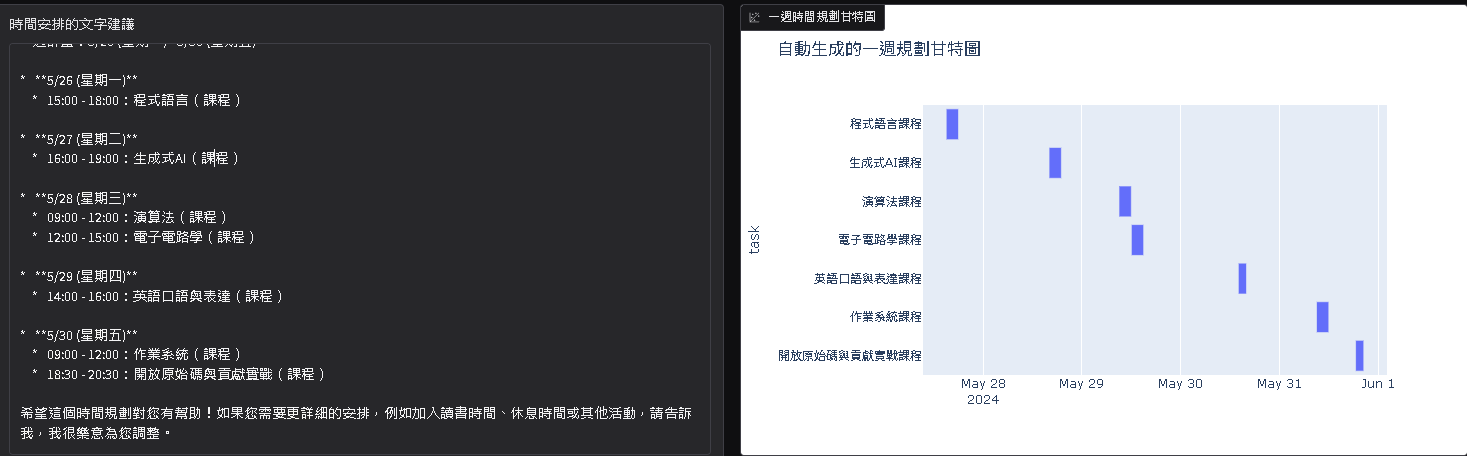

### \# 0.1

#### 輸入

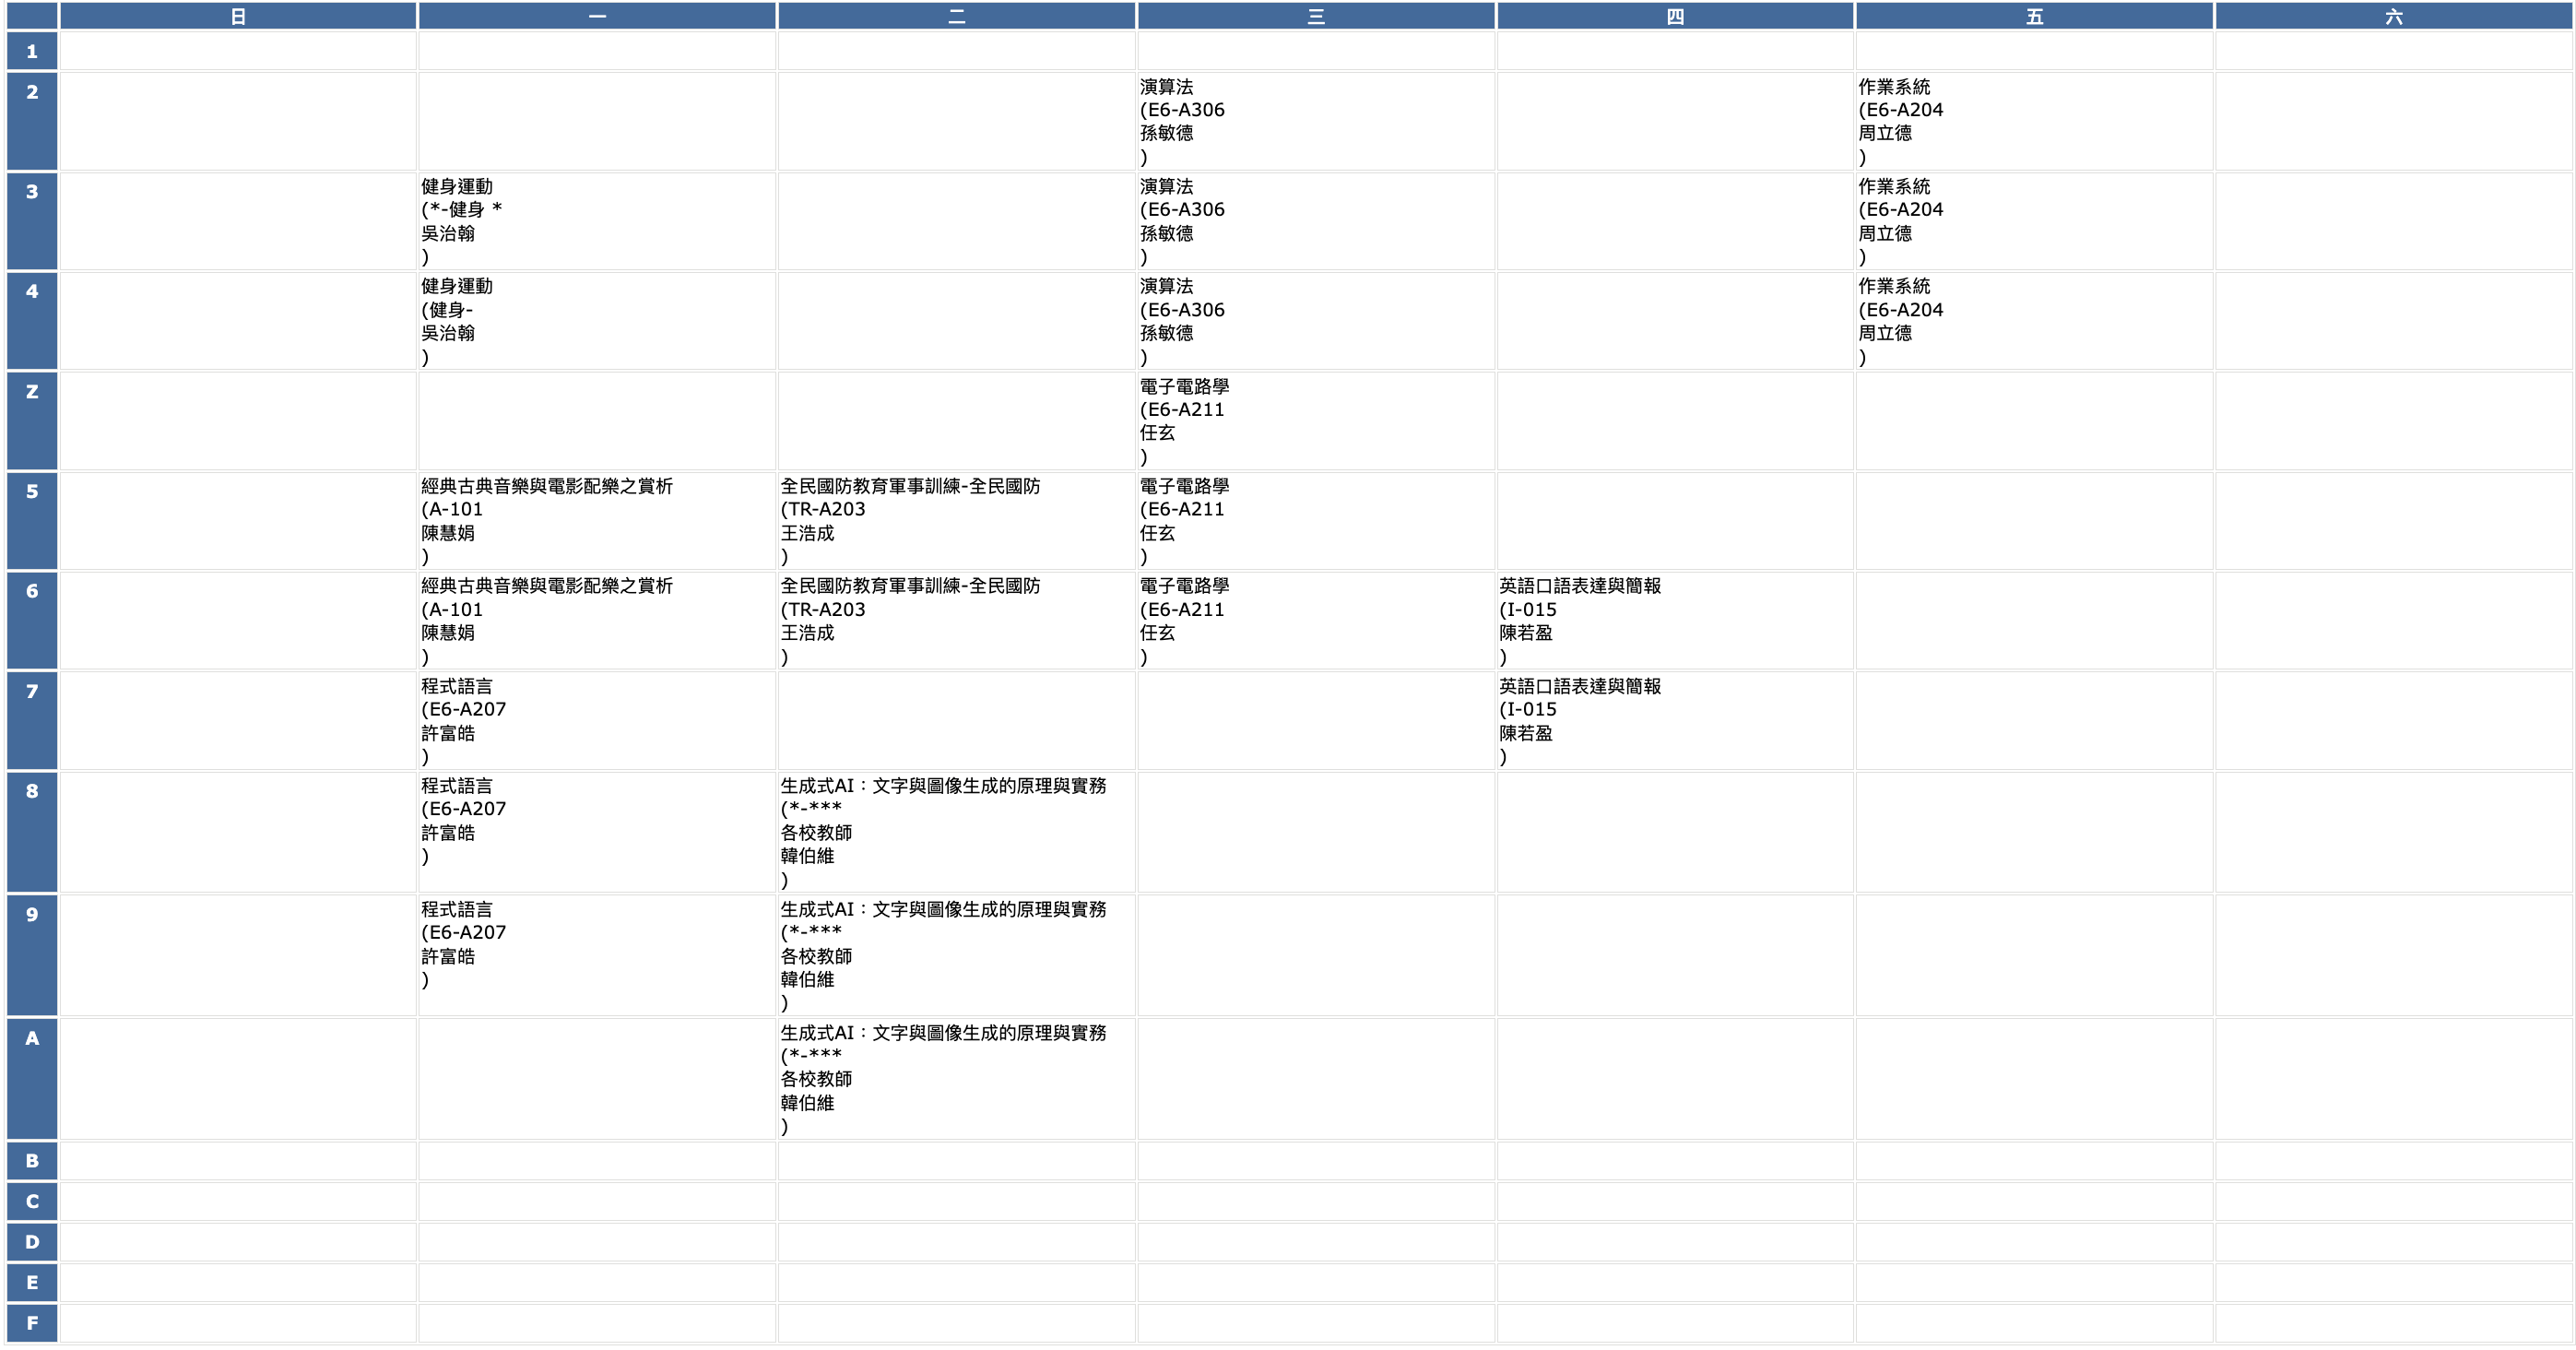

#### 輸出

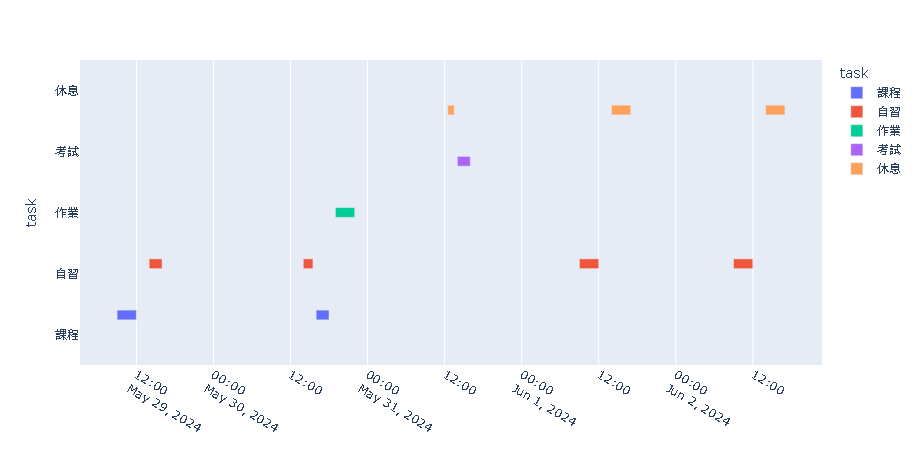

### \# 0.2

#### 輸入

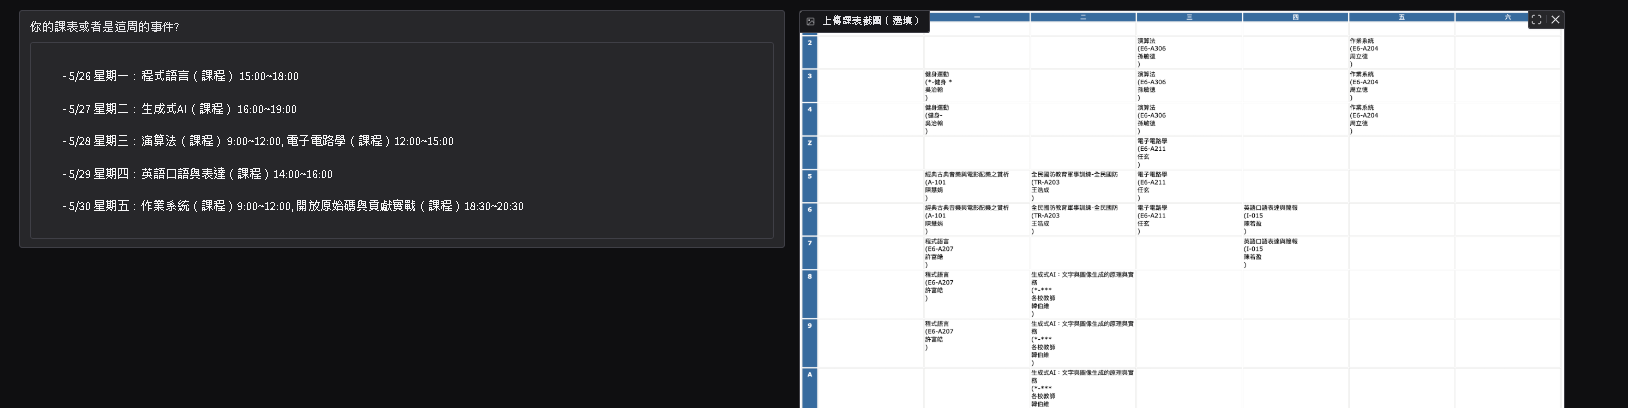

#### 輸出

# Reference

### 參考文章

* [ Plotly Python Graphing Library ]( https://plotly.com/python/ )( https://plotly.com/python/ )


* [ 資料視覺化(Data Visualization) — Python 套件 — 互動式繪圖 — Plotly介紹與構圖介面的函數詳解 — Plotly筆記(一) ]( https://chwang12341.medium.com/%E8%B3%87%E6%96%99%E8%A6%96%E8%A6%BA%E5%8C%96-data-visualization-python-%E5%A5%97%E4%BB%B6-%E4%BA%92%E5%8B%95%E5%BC%8F%E7%B9%AA%E5%9C%96-plotly%E4%BB%8B%E7%B4%B9%E8%88%87%E6%A7%8B%E5%9C%96%E4%BB%8B%E9%9D%A2%E7%9A%84%E5%87%BD%E6%95%B8%E8%A9%B3%E8%A7%A3-plotly%E7%AD%86%E8%A8%98-%E4%B8%80-aa4995b42a34 )( https://chwang12341.medium.com/%E8%B3%87%E6%96%99%E8%A6%96%E8%A6%BA%E5%8C%96-data-visualization-python-%E5%A5%97%E4%BB%B6-%E4%BA%92%E5%8B%95%E5%BC%8F%E7%B9%AA%E5%9C%96-plotly%E4%BB%8B%E7%B4%B9%E8%88%87%E6%A7%8B%E5%9C%96%E4%BB%8B%E9%9D%A2%E7%9A%84%E5%87%BD%E6%95%B8%E8%A9%B3%E8%A7%A3-plotly%E7%AD%86%E8%A8%98-%E4%B8%80-aa4995b42a34 )


* [ Day11 Data Visualization Tools: Plotly 視覺化資料工具：Plotly ]( https://ithelp.ithome.com.tw/m/articles/10214872 )( https://ithelp.ithome.com.tw/m/articles/10214872 )


* [ [Day 22] Python 視覺化解釋數據 - Plotly Express ]( https://ithelp.ithome.com.tw/articles/10277258 )( https://ithelp.ithome.com.tw/articles/10277258 )

### **LLM**

#### Gemini - 呼叫API
#### ChatGPT-4.5 - 精細、修改prompt